In [1]:
import geopandas as gpd
import momepy
import networkx as nx
from itertools import combinations, product
import shapely
import numpy as np
import pickle

from shapely import LineString
import math
from collections import Counter

import osmnx as ox
import time

## CLSE functions

In [2]:
def make_stroke_graph_clse(gdf, compute_metric=True, output="dataframe"):
    if output not in ["dataframe", "graph"]:
        raise ValueError("output need to be either dataframe or graph")
    # Transform into primal graph
    G_primal = momepy.gdf_to_nx(gdf, approach="primal", preserve_index=True)
    lines_primal = momepy.nx_to_gdf(G_primal, points=False, lines=True)
    # Use COINS on primal graph edges
    coins = momepy.COINS(lines_primal)
    # List the stroke for each edge
    stroke_attribute = coins.stroke_attribute()
    # List each edge for each stroke
    stroke_gdf = coins.stroke_gdf()
    stroke_gdf["edge_ids"] = [stroke_attribute[stroke_attribute == stroke_id].index.values for stroke_id in stroke_gdf.index.values]
    # Add stroke ID to each edge
    nx.set_edge_attributes(G_primal, {e: int(stroke_attribute[G_primal.edges[e]["index_position"]]) for e in G_primal.edges}, "stroke_id")
    # Create stroke graph
    G_stroke = nx.Graph()
    G_stroke.graph["crs"] = G_primal.graph["crs"]
    # Create a node for each stroke with the right features
    G_stroke.add_nodes_from([[int(idx), {(attr if attr != "geometry" else "geometry_stroke"):stroke_gdf.loc[idx][attr] for attr in list(stroke_gdf)}] for idx in stroke_gdf.index.values])
    # For all node, put its geometry at the center of the LineString
    for n in G_stroke.nodes:
        G_stroke.nodes[n]["geometry"] = stroke_gdf.iloc[n].geometry.interpolate(0.5, normalized=True)
        G_stroke.nodes[n]["x"] = G_stroke.nodes[n]["geometry"].xy[0]
        G_stroke.nodes[n]["y"] = G_stroke.nodes[n]["geometry"].xy[1]
        G_stroke.nodes[n]["length"] = G_stroke.nodes[n]["geometry_stroke"].length
    # Find strokes intersecting
    for n in G_primal.nodes:
        strokes_present = [G_primal.edges[e]["stroke_id"] for e in G_primal.edges(n, keys=True)]
        # If strokes intersecting, add the edge if not already present
        if len(set(strokes_present)) > 1:
            for u, v in combinations(set(strokes_present), 2):
                # Find all edges touching the node for both strokes checked
                edges_u = [e for e in G_primal.edges(n, keys=True) if G_primal.edges[e]["stroke_id"] == u]
                edges_v = [e for e in G_primal.edges(n, keys=True) if G_primal.edges[e]["stroke_id"] == v]
                angle_list = []
                angle_dict = {}
                # Choose the smallest list as number of angles kept
                chosen, other = sorted([edges_u, edges_v], key=len)
                # Find the angles
                for ce, oe in list(product(chosen, other)):
                    point = [G_primal.nodes[n]["x"], G_primal.nodes[n]["y"]]
                    gc = find_geom(G_primal.edges[ce]["geometry"], point)
                    go = find_geom(G_primal.edges[oe]["geometry"], point)
                    if ce in angle_dict:
                        angle_dict[ce].append(angle(gc, go))
                    else:
                        angle_dict[ce]= [angle(gc, go)]
                # Keep the smallest angles
                angle_list = [min(angle_dict[ekey]) for ekey in angle_dict]
                if G_stroke.has_edge(u, v):
                    G_stroke.edges[u, v]["angles"] += angle_list
                    G_stroke.edges[u, v]["number_connections"] = len(G_stroke.edges[u, v]["angles"])
                else:
                    G_stroke.add_edge(u, v, geometry = shapely.LineString([G_stroke.nodes[u]["geometry"], G_stroke.nodes[v]["geometry"]]), number_connections=len(angle_list), angles=angle_list)
    if compute_metric:
        nx.set_node_attributes(G_stroke, nx.betweenness_centrality(G_stroke), "stroke_betweenness")
        nx.set_node_attributes(G_stroke, nx.closeness_centrality(G_stroke), "stroke_closeness")
        nx.set_node_attributes(G_stroke, dict(nx.degree(G_stroke)), "stroke_degree")
        for n in G_stroke.nodes:
            G_stroke.nodes[n]["stroke_connectivity"] = sum([G_stroke.edges[e]["number_connections"] for e in G_stroke.edges(n)])
            G_stroke.nodes[n]["stroke_access"] = G_stroke.nodes[n]["stroke_connectivity"] - G_stroke.nodes[n]["stroke_degree"]
            angles = [val for e in G_stroke.edges(n) if G_stroke.edges[e]["angles"] for val in G_stroke.edges[e]["angles"]]
            G_stroke.nodes[n]["stroke_orthogonality"] = sum(angles) / G_stroke.nodes[n]["stroke_connectivity"]
            G_stroke.nodes[n]["stroke_spacing"] = G_stroke.nodes[n]["length"] / G_stroke.nodes[n]["stroke_connectivity"]
    if output == "dataframe":
        return momepy.nx_to_gdf(G_stroke, points=True, lines=True)
    elif output == "graph":
        return G_stroke

def angle(a, b):
    angle = np.rad2deg(np.arccos(np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))))
    if angle > 90:
        angle = 180 - angle
    return angle

def find_geom(linestring, point):
    if point == list(linestring.coords[0]):
        geom = [np.array(val) for val in linestring.coords[:2]]
    else:
        geom = [np.array(val) for val in linestring.coords[-2:]]
    return np.array(geom[0] - geom[1])

In [3]:
# define variable defaults (will be arguments passed to future function)
angle_threshold=0
flow_mode=False
# remove false nodes

def make_stroke_graph_anvy(gdf, compute_metric=True, output="dataframe"):
    # make primal graph
    graph = momepy.gdf_to_nx(
        gdf, 
        preserve_index=True, # index of lines gdf should be referring to EXACTLY THE SAME ELEMENT as index of streets gdf
        approach="primal"
    )
    # get gdfs of points and lines
    points, lines = momepy.nx_to_gdf(graph, points=True, lines=True)
    lines["my_index"] = lines.index # just for plotting TODO remove later
    # make coins
    coins = momepy.COINS(lines, angle_threshold=angle_threshold, flow_mode=flow_mode)
    # get gdfs from COINS class
    stroke_attribute = coins.stroke_attribute()
    stroke_gdf = coins.stroke_gdf()
    stroke_gdf["rep_point"] = stroke_gdf.geometry.apply(lambda x: x.interpolate(0.5, normalized=True))
    # add stroke_id column
    stroke_gdf["stroke_id"] = stroke_gdf.index
    # add edge_ids column (using COINS.stroke_attribute to map into ID defined in lines gdf)
    stroke_gdf["edge_indeces"] = stroke_gdf.stroke_id.apply(
        lambda x: list(stroke_attribute[stroke_attribute==x].index)
    )
    # make dictionary for primal graph: d={edge_index:edge_name}
    # where edge_name (in momepy language) is the corresponding node tuple
    d_name2index = nx.get_edge_attributes(graph, "index_position")
    d_index2name = {v:k for k,v in d_name2index.items()}
    # for each edge, add "stroke_id" as attribute to graph
    for _, row in stroke_gdf.iterrows():
        for edge_index in row.edge_indeces: 
            graph.edges[d_index2name[edge_index]]["stroke_id"] = row.stroke_id
    # getting dicts of edge name : stroke ID, and edge index : stroke id # TODO: one of them might be obsolete?
    d_name2stroke = nx.get_edge_attributes(graph, "stroke_id")
    d_index2stroke = {d_name2index[k]:v for k,v in d_name2stroke.items()} 
    stroke_graph = nx.Graph()
    stroke_graph.graph["crs"] = graph.graph["crs"]
    stroke_graph.graph["approach"] = graph.graph["approach"]
    stroke_graph.add_nodes_from(
        [
            (
                row.stroke_id, 
                {
                    "edge_indeces": row.edge_indeces,
                    "geometry": row.rep_point,
                    "geometry_stroke": row.geometry,
                    "x": row.rep_point.xy[0][0],
                    "y": row.rep_point.xy[1][0],
                    "connectivity": 0
                }
            ) for _, row in stroke_gdf.iterrows()
        ]
    )
    # node names are the stroke IDs.
    # each node has the attribute "edge_indeces".
    stroke_graph.nodes(data=True)
    for n in graph.nodes:
        es = list(graph.edges(n, keys=True))
        stroke_list = [graph.edges[e]["stroke_id"] for e in es]
        stroke_set = set(stroke_list)
        # for all size2 combinations from stroke_set
        for c in combinations(stroke_set, 2):
            # get angles at that primal node for this 2-stroke combination c
            es = list(graph.edges(n, keys=True))
            stroke_ids = [graph.edges[e]["stroke_id"] for e in es]
            geoms = [graph.edges[e]["geometry"] for e in es]
            segments = [get_segment(geom, n) for geom in geoms] # extracting only edge segments that touch this node
            angles_gdf = gpd.GeoDataFrame(
                {
                    "stroke_id": stroke_ids,
                    "segment": segments,
                    "geometry": [LineString(x) for x in segments]
                }
            )
            # filter out only those linestring that belong to current 2-stroke edge
            angles_gdf = angles_gdf[angles_gdf.stroke_id.isin(c)].reset_index(drop=True)
            if len(angles_gdf)==2:
                # connectivity equals 1 here
                connectivity = 1
                # angle between 2 strokes is just angle between 
                # the 2 linestrings in the gdf:
                row_a = angles_gdf.loc[0]
                row_b = angles_gdf.loc[1]
                angles = [
                    get_interior_angle(
                        row_a.segment[1],
                        row_a.segment[0],
                        row_b.segment[1]
                    )
                ]
            elif len(angles_gdf)==3:
                # connectivity equals 1 here
                connectivity = 1
                # the iteration has to go through the stroke that appears TWICE
                stroke_count = dict(Counter(angles_gdf.stroke_id))
                stroke_count = {v:k for k,v in stroke_count.items()}
                # separate angles_gdf into 2 separate gdf (one for each stroke)
                angles_stroke_a = angles_gdf[angles_gdf["stroke_id"]==stroke_count[1]].copy()
                angles_stroke_b = angles_gdf[angles_gdf["stroke_id"]==stroke_count[2]].copy()
                angles = []
                # there is only ONE row_a stroke segment
                for i, row_a in angles_stroke_a.iterrows():
                    angles_stroke = []
                    # iterate through BOTH stroke b segments
                    for j, row_b in angles_stroke_b.iterrows():
                        assert row_a.segment[0] == row_b.segment[0]
                        # compute angle between stroke a and stroke b segments
                        # and add to list of current angles
                        angles_stroke.append(get_interior_angle(
                            row_a.segment[1],
                            row_a.segment[0],
                            row_b.segment[1])
                        )
                # keep the smaller of the 2 angles to add to list of angles for the stroke pair
                angles.append(min(angles_stroke))
            elif len(angles_gdf)==4:
                # connectivity equals 2 here
                connectivity = 2
                # separate angles_gdf into 2 separate gdf (one for each stroke)
                angles_stroke_a = angles_gdf[angles_gdf["stroke_id"]==c[0]].copy()
                angles_stroke_b = angles_gdf[angles_gdf["stroke_id"]==c[1]].copy()
                angles = []
                # iterate through stroke a segments
                for i, row_a in angles_stroke_a.iterrows():
                    # iterate through stroke b segments
                    angles_partial = []
                    for j, row_b in angles_stroke_b.iterrows():
                        assert row_a.segment[0] == row_b.segment[0]
                        # compute angle between stroke a and stroke b segments
                        # and add to list of current angles
                        angle = get_interior_angle(
                            row_a.segment[1],
                            row_a.segment[0],
                            row_b.segment[1])
                        # if angle > 90:
                        #     angle = 180 - angle
                        angles_partial.append(angle)
                    angles.append(min(angles_partial)) # @csebastiao we're keeping the minimal here?
            else:
                ValueError(f"Length of angles_gdf expected to be in [2,3,4], but is {len(angles_gdf)}")
            # connectivity is added at stroke node level:
            for s in c:
                stroke_graph.nodes[s]["connectivity"] += connectivity
            # and edge (or update edge info) at stroke edge level:
            if c not in stroke_graph.edges:
                edge_geom = LineString(
                    [
                        stroke_graph.nodes[c[0]]["geometry"],
                        stroke_graph.nodes[c[1]]["geometry"]
                    ]
                )
                stroke_graph.add_edge(
                    c[0],
                    c[1],
                    geometry=edge_geom,
                    angles=angles
                )
            else:
                stroke_graph.edges[c]["angles"] += angles
    # we want to add edges for all stroke IDs that co-occur on edges that share the same node in the primal graph
    # [0, 1, 1] means: stroke0 has an endpoint here; stroke1 has a throughpoint here; we add the edge [0,1] in the strokes_graph, with the attribute 
    # stroke = {0: "end", 1: "through"}
    # add graph metrics
    # betweenness centrality dict for all nodes
    if compute_metric:
        bc = nx.betweenness_centrality(stroke_graph)
        # closeness centrality dict for all nodes
        cc = nx.closeness_centrality(stroke_graph)
        for n in stroke_graph.nodes:
            stroke_graph.nodes[n]["degree"] = nx.degree(stroke_graph, n)
            stroke_graph.nodes[n]["betweenness_centrality"] = bc[n]
            stroke_graph.nodes[n]["closeness_centrality"] = cc[n]
            # just for sanity check # TODO can be removed later
            stroke_graph.nodes[n]["connectivity_computed"] = sum(
                [len(stroke_graph.edges[edge]["angles"]) for edge in stroke_graph.edges(n)]
            )        
            assert stroke_graph.nodes[n]["connectivity"] == stroke_graph.nodes[n]["connectivity_computed"]
            # access = abs(connectivity - degree)
            stroke_graph.nodes[n]["access"] = abs(stroke_graph.nodes[n]["connectivity"] - stroke_graph.nodes[n]["degree"])
            # spacing = length / connectivity
            stroke_graph.nodes[n]["length"] = stroke_graph.nodes[n]["geometry_stroke"].length # compute length first
            stroke_graph.nodes[n]["spacing"] = stroke_graph.nodes[n]["length"] / stroke_graph.nodes[n]["connectivity"]
            # orthogonality = sum(angles) / connectivity
            # compute sum of angles of edges of that node first
            node_angles = [stroke_graph.edges[edge]["angles"] for edge in stroke_graph.edges(n)]
            node_angles = [item for sublist in node_angles for item in sublist] # un-nest list
            stroke_graph.nodes[n]["orthogonality"] = sum(node_angles)/stroke_graph.nodes[n]["connectivity"]
    if output == "dataframe":
        return momepy.nx_to_gdf(stroke_graph, points=True, lines=True)
    elif output == "graph":
        return stroke_graph

def get_interior_angle(a, b, c):
    """
    Measure the angle between a-b, b-c (in degrees).
    """
    ba = [a[0]-b[0],a[1]-b[1]]
    bc = [c[0]-b[0],c[1]-b[1]]
    # np.dot(ba, bc) # ba[0]*bc[0] + ba[1]*bc[1]
    # np.linalg.norm(ba) # np.sqrt(ba[0]**2+ba[1]**2)
    # np.linalg.norm(bc) # np.sqrt(bc[0]**2+bc[1]**2)
    theta_rad = math.acos(np.dot(ba,bc)/(np.linalg.norm(ba)*np.linalg.norm(bc)))
    theta_deg = np.degrees(theta_rad)
    if theta_deg > 90:
        theta_deg = 180 - theta_deg
    return theta_deg

def get_segment(geom, n):
    '''
    geom... linestring.
    n.... coordinate of start-or-end node on linestring.
    returns: coordinate tuple (n, adjacent-to-n), in THAT ORDER
        (ie. if n is start node, returns coords in position 0 and 1;
        if n is end node, reutnrs coords in position n, n-1
        )
    '''
    coords = [c for c in geom.coords]
    index_n = coords.index(n)
    if index_n == 0:
        return coords[0:2]
    elif index_n == len(coords)-1:
        return [coords[index_n], coords[index_n-1]]
    else:
        raise ValueError("Node not on end of edge?")

# use angles_gdf length to add to connectivity of strokes (nodes)
def get_connectivity(angles_gdf):
    if len(angles_gdf)==4:
        return 2
    elif len(angles_gdf) in [2,3]:
        return 1
    else:
        raise ValueError("Unexpected number of edge segments in angles_gdf")


In [4]:
gdf = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")
gdf = momepy.remove_false_nodes(gdf)

In [5]:
arr = []
for _ in range(100):
    beg = time.time()
    G_stroke_clse = make_stroke_graph_clse(gdf, compute_metric=True, output="graph")
    end = time.time()
    arr.append(end - beg)
np.mean(arr)

np.float64(0.03989638328552246)

In [6]:
arr = []
for _ in range(100):
    beg = time.time()
    G_stroke_anvy = make_stroke_graph_anvy(gdf, compute_metric=True, output="graph")
    end = time.time()
    arr.append(end - beg)
np.mean(arr)

np.float64(0.09599937915802002)

In [7]:
G = ox.graph_from_place("Aix-en-Provence, France")

In [8]:
G = ox.convert.to_undirected(G)

In [9]:
gdf = ox.graph_to_gdfs(
    G,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

In [10]:
gdf

osmid     highway  \
u           v           key                                                 
5536045     9460707230  0    [355742063, 147498237, 90283751]       trunk   
            277035488   0      [90283752, 90283753, 25419836]  trunk_link   
            1047001403  0     [685260154, 90283748, 90283751]       trunk   
5536052     265489026   0     [90731432, 31557546, 179308707]       trunk   
            8518453006  0     [90283320, 90283321, 179308930]  trunk_link   
...                                                       ...         ...   
12819726786 12819726793 0            [1384658856, 1384658857]       track   
12840723907 12840723918 0                          1387085145     footway   
12840723908 12840723913 0                          1387085143     service   
12840723911 12840723913 0                          1387085143     service   
12840723913 12840723915 0                          1387085144     footway   

                            lanes  maxspeed  \
u           v           key                   
5536045     9460707230  0       2  [90, 70]   
            277035488   0       1       110   
            1047001403  0       2        90   
5536052     265489026   0       2        50   
            8518453006  0     NaN        50   
...                           ...       ...   
12819726786 12819726793 0     NaN       NaN   
12840723907 12840723918 0     NaN       NaN   
12840723908 12840723913 0     NaN       NaN   
12840723911 12840723913 0     NaN       NaN   
12840723913 12840723915 0     NaN       NaN   

                                                           name  oneway  \
u           v           key                                               
5536045     9460707230  0    Avenue de la 1e Division Française    True   
            277035488   0                                   NaN    True   
            1047001403  0    Avenue de la 1e Division Française    True   
5536052     265489026   0    Avenue de la 1e Division Française    True   
            8518453006  0                                   NaN    True   
...                                                         ...     ...   
12819726786 12819726793 0                                   NaN   False   
12840723907 12840723918 0                                   NaN   False   
12840723908 12840723913 0                                   NaN   False   
12840723911 12840723913 0                                   NaN   False   
12840723913 12840723915 0                                   NaN   False   

                               ref reversed       length  \
u           v           key                                
5536045     9460707230  0    N 296    False  1038.297695   
            277035488   0      NaN    False   224.338024   
            1047001403  0    N 296    False   364.686411   
5536052     265489026   0    N 296    False   198.965351   
            8518453006  0      NaN    False   147.744228   
...                            ...      ...          ...   
12819726786 12819726793 0      NaN    False   117.859117   
12840723907 12840723918 0      NaN     True     8.950842   
12840723908 12840723913 0      NaN     True    33.678924   
12840723911 12840723913 0      NaN    False    28.646349   
12840723913 12840723915 0      NaN     True    42.460380   

                                                                      geometry  \
u           v           key                                                      
5536045     9460707230  0    LINESTRING (5.44934 43.55847, 5.44908 43.55836...   
            277035488   0    LINESTRING (5.45133 43.55971, 5.45138 43.55962...   
            1047001403  0    LINESTRING (5.45305 43.56034, 5.45259 43.56007...   
5536052     265489026   0    LINESTRING (5.43573 43.55346, 5.43543 43.55318...   
            8518453006  0    LINESTRING (5.43573 43.55346, 5.43558 43.55335...   
...                                                                        ...   
12819726786 12819726793 0    

In [11]:
gdf = gdf.to_crs(epsg=3857)
gdf = gdf[~gdf.geometry.duplicated()]

In [12]:
gdf

osmid     highway  \
u           v           key                                                 
5536045     9460707230  0    [355742063, 147498237, 90283751]       trunk   
            277035488   0      [90283752, 90283753, 25419836]  trunk_link   
            1047001403  0     [685260154, 90283748, 90283751]       trunk   
5536052     265489026   0     [90731432, 31557546, 179308707]       trunk   
            8518453006  0     [90283320, 90283321, 179308930]  trunk_link   
...                                                       ...         ...   
12819726786 12819726793 0            [1384658856, 1384658857]       track   
12840723907 12840723918 0                          1387085145     footway   
12840723908 12840723913 0                          1387085143     service   
12840723911 12840723913 0                          1387085143     service   
12840723913 12840723915 0                          1387085144     footway   

                            lanes  maxspeed  \
u           v           key                   
5536045     9460707230  0       2  [90, 70]   
            277035488   0       1       110   
            1047001403  0       2        90   
5536052     265489026   0       2        50   
            8518453006  0     NaN        50   
...                           ...       ...   
12819726786 12819726793 0     NaN       NaN   
12840723907 12840723918 0     NaN       NaN   
12840723908 12840723913 0     NaN       NaN   
12840723911 12840723913 0     NaN       NaN   
12840723913 12840723915 0     NaN       NaN   

                                                           name  oneway  \
u           v           key                                               
5536045     9460707230  0    Avenue de la 1e Division Française    True   
            277035488   0                                   NaN    True   
            1047001403  0    Avenue de la 1e Division Française    True   
5536052     265489026   0    Avenue de la 1e Division Française    True   
            8518453006  0                                   NaN    True   
...                                                         ...     ...   
12819726786 12819726793 0                                   NaN   False   
12840723907 12840723918 0                                   NaN   False   
12840723908 12840723913 0                                   NaN   False   
12840723911 12840723913 0                                   NaN   False   
12840723913 12840723915 0                                   NaN   False   

                               ref reversed       length  \
u           v           key                                
5536045     9460707230  0    N 296    False  1038.297695   
            277035488   0      NaN    False   224.338024   
            1047001403  0    N 296    False   364.686411   
5536052     265489026   0    N 296    False   198.965351   
            8518453006  0      NaN    False   147.744228   
...                            ...      ...          ...   
12819726786 12819726793 0      NaN    False   117.859117   
12840723907 12840723918 0      NaN     True     8.950842   
12840723908 12840723913 0      NaN     True    33.678924   
12840723911 12840723913 0      NaN    False    28.646349   
12840723913 12840723915 0      NaN     True    42.460380   

                                                                      geometry  \
u           v           key                                                      
5536045     9460707230  0    LINESTRING (606617.776 5397366.114, 606588.822...   
            277035488   0    LINESTRING (606839.625 5397557.657, 606845.102...   
            1047001403  0    LINESTRING (607030.872 5397653.622, 606980.066...   
5536052     265489026   0    LINESTRING (605102.985 5396597.832, 605069.767...   
            8518453006  0    LINESTRING (605102.985 5396597.832, 605085.53 ...   
...                                                                        ...   
12819726786 12819726793 0    

In [13]:
beg = time.time()
G_stroke_clse = make_stroke_graph_clse(gdf, compute_metric=True, output="graph")
print(time.time() - beg)

/var/folders/mb/_ysy1pzs13qgnh9b942_7lkh0000gn/T/ipykernel_14835/721137014.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nx.set_edge_attributes(G_primal, {e: int(stroke_attribute[G_primal.edges[e]["index_position"]]) for e in G_primal.edges}, "stroke_id")


498.3172490596771


<Axes: >

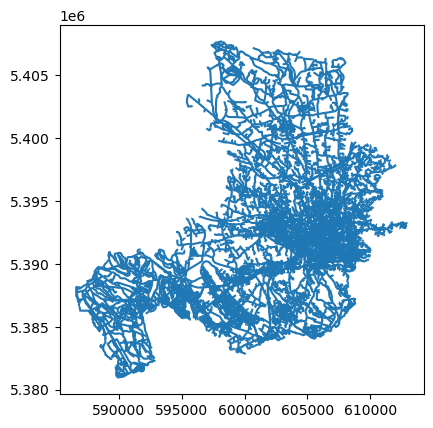

In [20]:
gdf.plot()

In [15]:
beg = time.time()
G_stroke_anvy = make_stroke_graph_anvy(gdf, compute_metric=True, output="graph")
print(time.time() - beg)

KeyError: (5536045, 9460707230, 0)